In [9]:
import numpy as np
from pybrain.supervised.trainers import BackpropTrainer
import pybrain as pb
import os
import json
from IPython.display import display, Math, Latex

import pandas as pd

RANDOM_STATE = 0

## Neural networks as a universal approximator

### Task 1

In [2]:
from pybrain.structure import FeedForwardNetwork, LinearLayer, SigmoidLayer, FullConnection, TanhLayer, SoftmaxLayer


layer_dic = {
    "linear": LinearLayer,
    "tanh": TanhLayer,
    "sigm": SigmoidLayer,
    "softmax": SoftmaxLayer
}

def get_net(hidden_n, input_n=1, output_n=1,
           input_layer_type='linear', hidden_layer_type='tanh', output_layer_type='linear'):
    """
    Function to get simple FeedForward Network with hidden layer
    :param hidden_n: number of dimensions of hidden layer
    :param input_n: number of input dimension. Default is 1
    :param output_n: number of output dimension. Default is 1
    :return: FeedForwardNetwork object with set up layers and connections
    """
    
    # Inital network
    net = FeedForwardNetwork()
    
    # Input layer
    in_layer = layer_dic[input_layer_type](input_n, "input")
    
    # Hidden layer
    hidden_layer = layer_dic[hidden_layer_type](hidden_n, "hidden")
    
    # Output layer
    out_layer = layer_dic[output_layer_type](output_n, "output")
    
    net.addInputModule(in_layer)
    net.addModule(hidden_layer)
    net.addOutputModule(out_layer)
    
    
    in_to_hidden = FullConnection(in_layer, hidden_layer)
    hidden_to_out = FullConnection(hidden_layer, out_layer)
    
    net.addConnection(in_to_hidden)
    net.addConnection(hidden_to_out)
    net.sortModules()
    
    return net

### Task 2

In [3]:
from pybrain.datasets import SupervisedDataSet, ClassificationDataSet

def get_train_and_test_sets(train_bound=(-3, 2), test_bound=[(-3, 2), (-3, 3)], train_size=2000, test_size=1000):
    """
    Function returns train and test datasets required for neural network
    """
    
    if type(train_bound) == tuple:
        X_train = np.random.uniform(train_bound[0], train_bound[1], train_size)
    else:
        X_train_1 = np.random.uniform(train_bound[0][0], train_bound[0][1], train_size / 2)
        X_train_2 = np.random.uniform(train_bound[1][0], train_bound[1][1], train_size / 2)
        X_train = np.vstack((X_train_1, X_train_2)).reshape(train_size)
        pass
    y_train = X_train ** 3
    
    X_test_1 = np.random.uniform(test_bound[0][0], test_bound[0][1], test_size)
    X_test_2 = np.random.uniform(test_bound[1][0], test_bound[1][1], test_size)

    y_test_1 = X_test_1 ** 3
    y_test_2 = X_test_2 ** 3
    
    train_set = ClassificationDataSet(1, 1)
    test_set_1 = ClassificationDataSet(1, 1)
    test_set_2 = ClassificationDataSet(1, 1)
    
    for i in xrange(train_size):
        train_set.addSample(X_train[i], y_train[i])
        
        # It is better than two for loops
        if i < test_size:
            test_set_1.addSample(X_test_1[i], y_test_1[i])
            test_set_2.addSample(X_test_2[i], y_test_2[i])
            
            
    return train_set, test_set_1, test_set_2

In [5]:
from pybrain.tools.validation import ModuleValidator
from pybrain.supervised.trainers import BackpropTrainer


from pybrain.tools.customxml.networkwriter import NetworkWriter
from pybrain.tools.customxml.networkreader import NetworkReader

class NeuralNetworkClassifier:
    
    network = None
    trainer = None
    
    networks = []
    trainers = []
    
    current_network = None
    current_trainer = None
    
    single_network = False
    
    
    network_file_name_pattern = "network"
    network_file_extension = '.xml'
    
    network_file = None
    networks_files = []
    dataset_file = None
    dataset_files = []
    
    
    last_epochs = None
    current_epochs = None
    
    
    def __init__(self, write_file=True):
        
        self.network_file = self.network_file_name_pattern + self.network_file_extension
        self.dataset_file = "dataset.json"
        self.write_file = write_file
        
        pass
    def __write_datasets(self):
        """
        Writing datasets set in classifier to compare it with new neural network
        """
        
        path = '{0}/{1}'.format(self.directory(), self.dataset_file)
        
        if not os.path.exists(self.directory()):
            os.makedirs(self.directory())
        
        dd = dict(self.current_trainer.ds.__dict__['data'])
        dd['input'] = dd['input'].tolist()
        dd['target'] = dd['target'].tolist()
        
        del dd['class']
        
        with open(path, 'w') as outfile:
            json.dump(dd, outfile)
    
    def __read_datasets(self):
        """
        Trying to find dataset assosiated with current network classifier working on
        Assosiated dataset is chosen according to number of neurons, number of epochs
        and current random state of generator (to distinguish different datasets from each task)
        """
        pack0 = RANDOM_STATE
        pack1 = self.current_network.modulesSorted[1].indim
        pack2 = self.last_epochs

        directory = 'networks/{0}/{1}/{2}'.format(pack0, pack1, pack2)
        
        path = '{0}/{1}'.format(directory, self.dataset_file)
        
        
        with open(path, 'r') as infile:
            dic = json.loads(infile.read())
        
        return dic
    
    def __check_datasets(self):
        """
        Checks, if current network has same dataset as founded
        """
        old_dataset = self.__read_datasets()
        
        new_dataset = dict(self.current_trainer.ds.__dict__['data'])
        new_dataset['input'] = new_dataset['input'].tolist()
        new_dataset['target'] = new_dataset['target'].tolist()
        
        
        old_input = old_dataset['input']
        old_target = old_dataset['target']
        
        new_input = new_dataset['input']
        new_target = new_dataset['target']
        
        return new_input == old_input and new_target == old_target
    
    def __layers_equal(self, layer1, layer2):
        """
        Checks, if two layers are equal
        Args:
            layer1, layer2: two layers of type pybrain.structure.modules.neuronlayer.NeuronLayer
        Returns:
            False, if layers have different types
            False, if they have different names
            False, if they have different field values
            True, if required field are the same
        """
        if type(layer1) != type(layer2):
            return False
        if layer1.name != layer2.name:
            return False

        # Those keys appears during training, but task is to avoid extra training
        unused_keys = ['_name', 'inputbuffer', 'outputbuffer', 'inputerror', 'outputerror']
        layer1_dict = {key: layer1.__dict__[key] for key in layer1.__dict__ if key not in unused_keys}
        layer2_dict = {key: layer2.__dict__[key] for key in layer2.__dict__ if key not in unused_keys}

        return layer1_dict == layer2_dict
    
    def __check_layers(self, network1, network2):
        """
        Checks if all corresponding layers in two networks are equal
        Args:
            network1, network2: two networks to be checked of type pybrain.structure.FeedForwardNetwork
        Returns:
            True if all layers are equal
            False otherwise
        """
        mds1 = network1.modulesSorted
        mds2 = network2.modulesSorted

        for m1, m2 in zip(mds1, mds2):
            if not self.__layers_equal(m1, m2):
                return False
        
        return True
    
    def __check_connections(self, con1, con2):
        """
        Checks if all connections between layers in two networks are the same
        Args:
            con1, con2 – two list of different networks' connections of type pybrain.structure.connections.FullConnection
        Returns:
            True, if connections are same
            False, otherwise
        """
        con1_dic = dict(con1)
        con2_dic = dict(con2)

        length = len(con1)

        con1_new = {}
        con2_new = {}

        for (key1, connect1), (key2, connect2) in zip(con1_dic.items(), con2_dic.items()):
            name1 = key1.name
            name2 = key2.name


            for conn1 in connect1:
                inmod1 = conn1.inmod.name
                outmod1 = conn1.outmod.name
                con1_new[name1] = [inmod1, outmod1]

            for conn2 in connect2:
                inmod2 = conn2.inmod.name
                outmod2 = conn2.outmod.name
                con2_new[name2] = [inmod2, outmod2]


        return con1_new == con2_new
    
    def __write_to_file(self):
        """
        Writes to xml-file network on which classifier works currently on
        Structure of file path: 
        'networks/*random_state*/*network num of neurons*/*number of epochs*/network.xml'
        """
        
        # So, we must save all possible networks to file 
        # to not to learn them again and again
        # First package: number of hidden layers
        pack0 = RANDOM_STATE
        pack1 = self.current_network.modulesSorted[1].indim
        # Second package: Number of epochs
        pack2 = self.last_epochs

        pack3 = self.network_file


        directory = 'networks/{0}/{1}/{2}'.format(pack0, pack1, pack2)

        if not os.path.exists(directory):
            os.makedirs(directory)

        network_file = '{0}/{1}'.format(directory, pack3)

        NetworkWriter.writeToFile(self.current_network, network_file)
    
    def directory(self):
        """
        Function-helper to get right directory for file writing
        """
        
        pack0 = RANDOM_STATE
        
        pack1 = self.current_network.modulesSorted[1].indim
        
        pack2 = self.current_epochs
        
        return 'networks/{0}/{1}/{2}'.format(pack0, pack1, pack2)
    
    
    def __get_existing_network(self, name, network_to_compare=None):
        """
        Tries to find network on disk, comparing with existing network.
        Args:
            name: filename of a network to find
            network_to_compare: existing network to compare with network from file
        Returns:
            None if networks have differences
            Readed from xml-file neural network otherwise
        """
        path = "{0}/{1}".format(self.directory(), name)
        
        try:
            nt = NetworkReader.readFrom(path)

            if not network_to_compare:
                return nt
            else:
                if not self.__check_layers(nt, network_to_compare):
                    return None
                if not self.__check_connections(nt.connections, network_to_compare.connections):
                    return None
                if self.last_epochs and not self.__check_datasets():
                    return None
        except IOError as e:
            return None
        
        return nt
    
    
    def train(self, epochs=1):
        """
        Public function avaiable to user
        Chooses which training type to select (either with single network, or with multiply)
        and calls corresponding function
        Args:
            epochs: number of iterations for training, used in Descent gradient method. Default is 1
        """
        if self.single_network:
            self.current_network = self.network
            self.current_trainer = self.trainer
            self.__train(epochs=epochs)
        else:
            self.__train_multy(epochs)
    
    def __train(self, epochs):
        """
        Trains current network with specified amount of epochs
        Firtly, tries to find already trained network with 
        same parameters (epochs, neurons, dataset)
        Args:
            epochs: number of iterations for training, used in Descent gradient method.
        """
        self.current_epochs = epochs
        make_none = False
        readed_network = None
        
        if self.last_epochs:
            if epochs != self.last_epochs:
                readed_network = None
                make_none = True
            else:
                readed_network = self.__get_existing_network(
                    name=self.network_file, network_to_compare=self.current_network)    
        else:
            readed_network = self.__get_existing_network(name=self.network_file, 
                                                         network_to_compare=self.current_network)
        
        if readed_network is None or make_none:
            self.current_trainer.trainEpochs(epochs=epochs)
        else:
            network = readed_network
                
        self.last_epochs = epochs
        
        
        # If something was found – no purpose to overwrite it again
        if not readed_network:
            self.__write_to_file()
            self.__write_datasets()
        
    
    def __train_multy(self, epochs):
        """
        Private function that's called if mupliply networks was provided
        Function iterates over list of networks and trainers and calls train
        method on each of it
        Args:
            epochs: number of iterations for training, used in Descent gradient method.
        """
        for trainer, network in zip(self.trainers, self.networks):
            self.current_network = network
            self.current_trainer = trainer
            
            self.__train(epochs)
            
            print 'Trained net with {0} neurons'.format(network.modulesSorted[1].indim)
        
    
    def error(self, test_data):
        """
        Function calculates Mean squared error (MSE), basing on given test set.
        Args:
            test_data: list of labels to test classifier
        Returns:
            MSE of fitted network if it is only in classifier
            List of MSE of fitted networks if there are many of them
            
        """
        if self.single_network:
            return ModuleValidator.MSE(self.network, test_data)
        else:
            return [ModuleValidator.MSE(network, test_data) for network in self.networks]
    
    def __fit(self, train_set, neurons_num, weight_decay, kwargs):
        """
        Function creating network and trainer based on given parameters
        Args:
            train_set: ClassificationDataSet object containing values and labels
            neurons_num: number of dimensions of network's hidden layer
            weight_decay: L2 regularization coefficient (used in Descent gradient method).
        """
        network = get_net(neurons_num, **kwargs)
        trainer = BackpropTrainer(network, train_set, weightdecay=weight_decay)
        trainer.setData(train_set)
        
        return network, trainer
        
    
    def fit(self, train_set, neurons_num=None, neurons_array=None, weight_decay=0.00001,
           kwargs={}):
        """
        Fit the model according to then given training data.
        Fitted can be either neurons_num or neurons_array. If neurons_num is set, 
        classifier works on one network, else – on mupliply, given in neurons_array
        
        Args:
            train_set: ClassificationDataSet object containing values and labels
            neurons_num: number of dimensions of network's hidden layer. Cannot be together with neurons_array
            neurons_array: array of neurons sized N, based on which N networks are constructed. 
            Cannot be together with neurons_num
            weight_decay: L2 regularization coefficient (used in Descent gradient method).
            **kwargs: additional arguments to neural network
        """
        if neurons_num and neurons_array:
            raise TypeError('Either num of neurons or neurons num array can be passed to function')
        
        self.network = None
        self.trainer = None
        self.networks = []
        self.trainers = []
        
        # If user passed neurons arrays – there would be mulpiply trainers
        if neurons_array:
            # We will have mupliply networks
            self.single_network = False
            for neur in neurons_array:
                network, trainer = self.__fit(train_set, neur, weight_decay, kwargs)
                self.networks.append(network)
                self.trainers.append(trainer)
                self.current_network = network
                self.current_trainer = trainer
        
        # Otherwise – only one
        else:
            self.single_network = True
            # We have only one network
            self.network, self.trainer = self.__fit(train_set, neurons_num, weight_decay, kwargs)
            self.current_network = self.network
            self.current_trainer = self.trainer
        
        self.current_network = None
        self.current_trainer = None
    

### Task 3

In [7]:
# Getting prepared for net
train_set, test_set_1, test_set_2 = get_train_and_test_sets()

In [11]:
# Training classificator on different neurons
neurons = range(1, 100, 10)
epoch = 100

nnc = NeuralNetworkClassifier()

nnc.fit(train_set=train_set, neurons_array=neurons)

nnc.train(epoch)

In [7]:
MSE_1 = nnc.error(test_set_1)
MSE_2 = nnc.error(test_set_2)

In [ ]:
nnc.networks[0].modules

#### Mean squared error

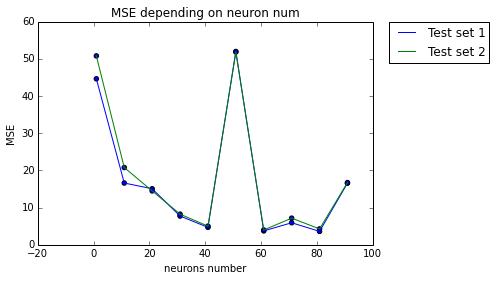

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = 1

plt.figure(figure)
plt.title('MSE depending on neuron num')
plt.xlabel('neurons number')
plt.ylabel('MSE')
plt.plot(neurons, MSE_1, label='Test set 1')
plt.scatter(neurons, MSE_1)
plt.plot(neurons, MSE_2, label='Test set 2')
plt.scatter(neurons, MSE_2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Task 3-a

According to this graph, 40 neurons are enough to approximate function on this interval.

#### Task 3-b

On some intervals first test set shows better accuracy (what can be connected with bigger than training bounds of second test set), but difference between MSE is not significant. 

### Task 4

#### Approximation of function given by nets

In [11]:
# second_train_set, second_test_set_1, second_test_set_2 = get_train_and_test_sets((-3, 3))
neurons = [1, 5, 10, 20, 50, 100, 200]

nnc = NeuralNetworkClassifier()

nnc.fit(second_train_set, neurons_array=neurons)

nnc.train(100)

Trained net with 1 neurons
Trained net with 5 neurons
Trained net with 10 neurons
Trained net with 20 neurons
Trained net with 50 neurons
Trained net with 100 neurons
Trained net with 200 neurons


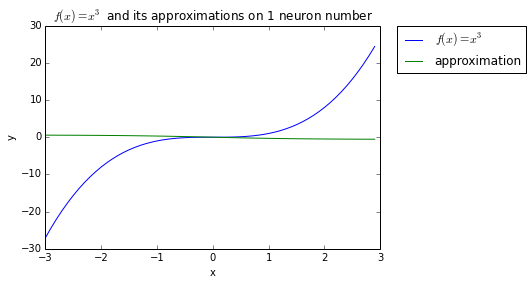

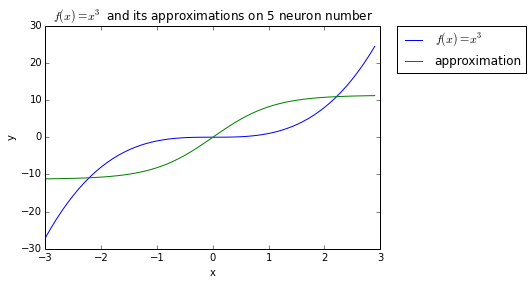

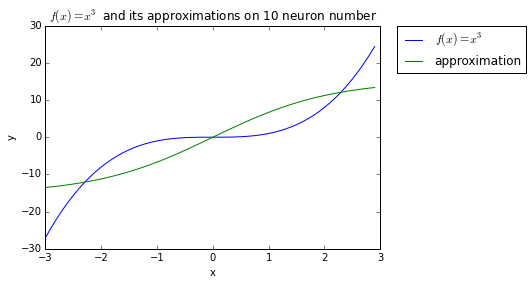

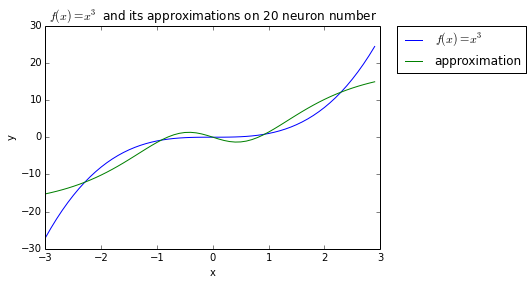

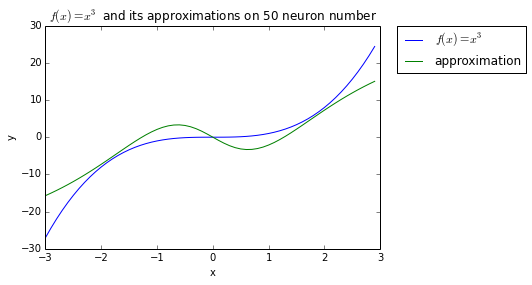

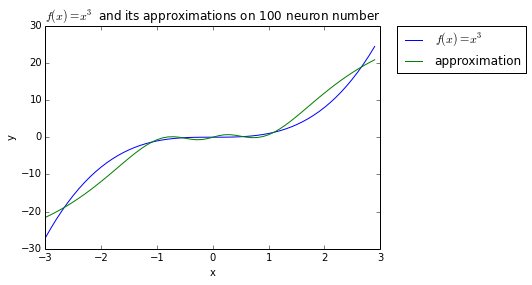

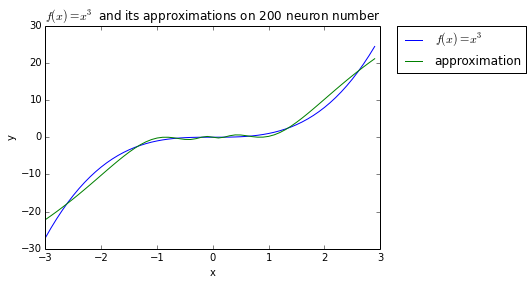

In [12]:
fig = 0
for neur in neurons:
    fig += 1
    
    plt.figure(fig)
    
    plt.title('$f(x)=x^3$ and its approximations on %s neuron number' % neur)
    plt.xlabel('x')
    plt.ylabel('y')
    
    net = nnc.networks[fig - 1]
    
    x_range = np.arange(-3.0, 3.0, 0.1)
    
    plt.plot(x_range, x_range ** 3, label='$f(x)=x^3$')
    plt.plot(x_range, np.array([net.activate([x]) for x in x_range]), label='approximation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

### Task 5 (3')

In [13]:
third_train_set, third_test_set_1, third_test_set_2 = get_train_and_test_sets(train_bound=[(-3, 1),(2, 3)])

neurons = range(1, 100, 10)
epoch = 100

nnc = NeuralNetworkClassifier()

nnc.fit(train_set=third_train_set, neurons_array=neurons)

nnc.train(epoch)

Trained net with 1 neurons
Trained net with 11 neurons
Trained net with 21 neurons
Trained net with 31 neurons
Trained net with 41 neurons
Trained net with 51 neurons
Trained net with 61 neurons
Trained net with 71 neurons
Trained net with 81 neurons
Trained net with 91 neurons


In [14]:
MSE_1 = nnc.error(third_test_set_1)
MSE_2 = nnc.error(third_test_set_2)

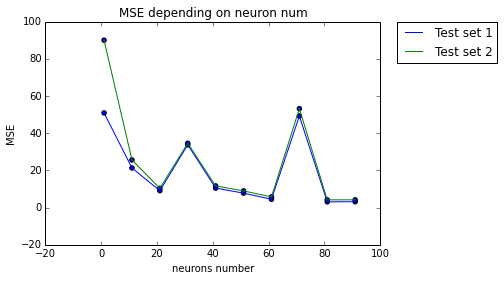

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = 1

plt.figure(figure)
plt.title('MSE depending on neuron num')
plt.xlabel('neurons number')
plt.ylabel('MSE')
plt.plot(neurons, MSE_1, label='Test set 1')
plt.scatter(neurons, MSE_1)
plt.plot(neurons, MSE_2, label='Test set 2')
plt.scatter(neurons, MSE_2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

MSE graph with new domain has some differences. Because network is trained on smaller interval than tested and there is a "hole" in comparing test and train interval, MSE is bigger on both sets. Also, there are more picks in graph than in original network, what I also can connect with piecewise of train set. 

### Task 5 (4')

In [16]:
RANDOM_STATE = 3

fourth_train_set, fourth_test_set_1, fourth_test_set_2 = get_train_and_test_sets(train_bound=[(-3, 1),(2, 3)])
neurons = [1, 5, 10, 20, 50, 100, 200]

nnc = NeuralNetworkClassifier()

nnc.fit(fourth_train_set, neurons_array=neurons)

nnc.train(100)

Trained net with 1 neurons
Trained net with 5 neurons
Trained net with 10 neurons
Trained net with 20 neurons
Trained net with 50 neurons
Trained net with 100 neurons
Trained net with 200 neurons


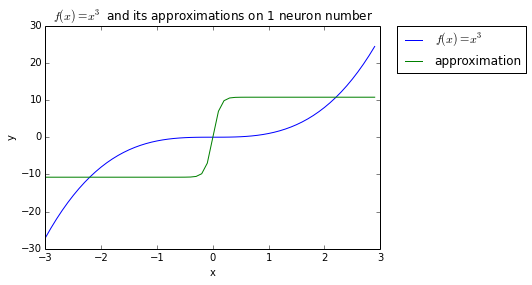

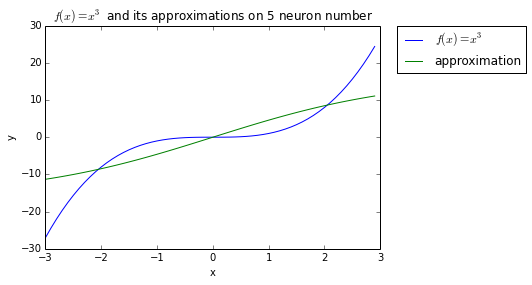

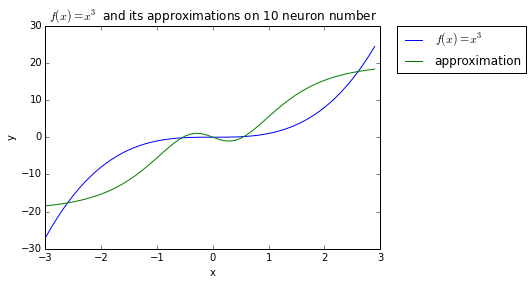

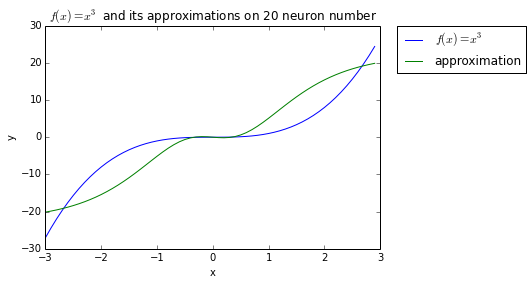

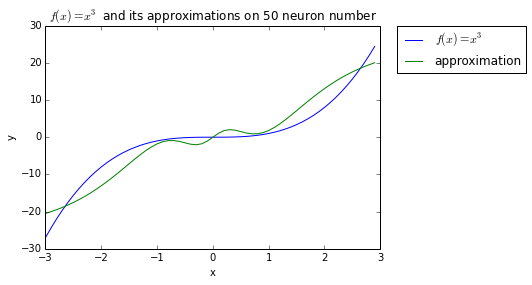

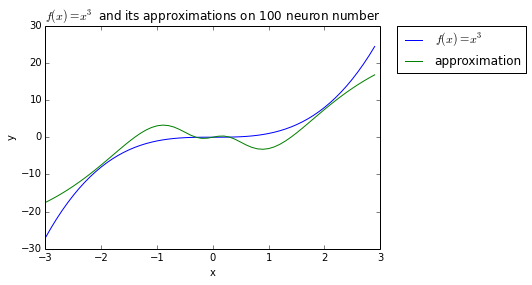

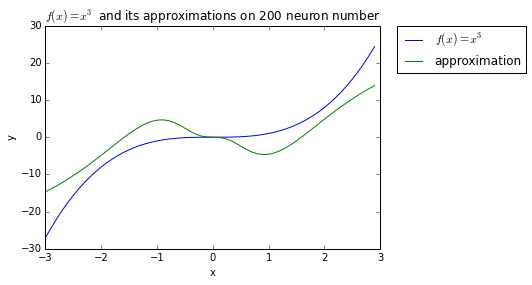

In [17]:
fig = 0
for neur in neurons:
    fig += 1
    
    plt.figure(fig)
    
    plt.title('$f(x)=x^3$ and its approximations on %s neuron number' % neur)
    plt.xlabel('x')
    plt.ylabel('y')
    
    net = nnc.networks[fig - 1]
    
    x_range = np.arange(-3.0, 3.0, 0.1)
    
    plt.plot(x_range, x_range ** 3, label='$f(x)=x^3$')
    plt.plot(x_range, np.array([net.activate([x]) for x in x_range]), label='approximation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

From approximation graph can be also seen, that accuracy is smaller. On some of graphs this missed domain (1, 2) hightlights and have one of the biggest error. Nevertheless, not only those pieces are badly predicted and it can be concluded, that poor training interval hurts not only its "holes", but whole approximator.

## Neural networks as a universal approximator

### Task 1

In [22]:
mnist_train_data = ClassificationDataSet.loadFromFile('mnist_train')
mnist_test_data = ClassificationDataSet.loadFromFile('mnist_test')

### Task 2 – 3

In [47]:
kwargs = {"input_n": 28 * 28,
          "output_n": 10,
          "input_layer_type": "linear", 
          "hidden_layer_type": "sigm", 
          "output_layer_type": "softmax"}

# RANDOM_STATE = 3

# nnc = NeuralNetworkClassifier()
# nnc.fit(mnist_train_data, neurons_num=30, weight_decay=0.001, kwargs=kwargs)


mnist_network = NetworkReader.readFrom('mnist_network.xml')

In [24]:
# nnc.train(epochs=25)

### Task 4

In [48]:
mnist_hidden_layer = mnist_network.modulesSorted[1]
mnist_connections = mnist_network.connections

In [49]:
l = mnist_network['input']
c = mnist_network.connections[l]
images = c[0].params.reshape(30, 28, 28)

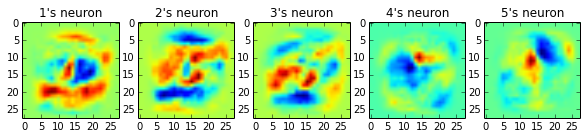

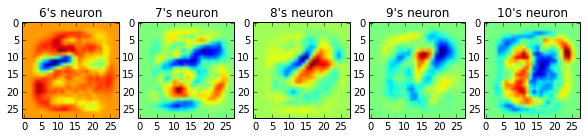

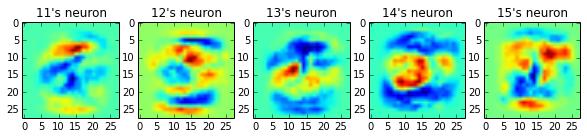

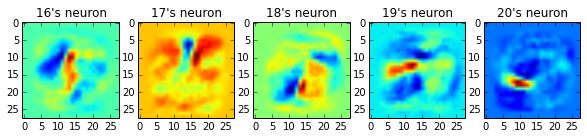

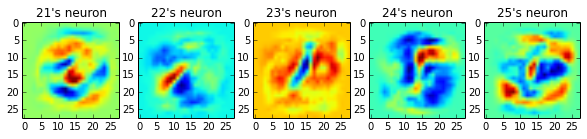

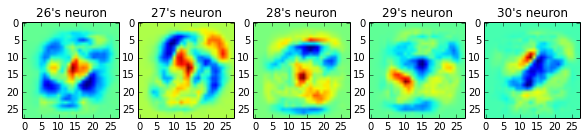

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

idx = 0

for i in range(6):
    fig = plt.figure(figsize=(10, 6))
    for j in range(5):
        a = fig.add_subplot(1, 5, j + 1)
        a.set_title('{0}\'s neuron'.format(idx + 1))
        plt.imshow(images[idx])
        idx += 1
        


Each of those pictures shows intensivity of connection between each neuron 
and input layer. 
Each picture also can be described as hidden neuron map of sensitivity to input neurons. More red – input neuron assosiated with this area on the map has more possibility to turn on this neuron, blue – otherwise. 

### Task 5

In [51]:
def transform_image(img):
    mnist_network.activate(img)
    return mnist_hidden_layer.outputbuffer[mnist_hidden_layer.offset]

In [52]:
element_count = mnist_train_data['input'].shape[0]
mnist_train_transformed = np.empty((element_count, 30))

for i in xrange(element_count):
    mnist_train_transformed[i] = transform_image(mnist_train_data['input'][i])

element_count = mnist_test_data['input'].shape[0]
mnist_test_transformed = np.empty((element_count, 30))

for j in xrange(element_count):
    mnist_test_transformed[j] = transform_image(mnist_test_data['input'][j])

array([1, 3, 5, 7, 2, 0, 4])

In [124]:


y_train = mnist_train_data['class']
y_sample = y_train[:10].reshape(10)
x_sample = mnist_train_transformed[:10].T

un = np.unique(y_sample, return_index=True)[1]
y_sample = y_sample[un]
x_sample = x_sample.T[un].T


df3 = pd.DataFrame(x_sample,
                 columns=y_sample)


def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0.5 else 'black'
    return 'color: %s' % color

s = df3.style.applymap(color_negative_red)
s


After such trainsforming of image we got matrix 60000 x 30

To visualize it 7 unique objects was selected, low values was marked red.
Objects probably can be distinguished from each other, but with no knowlege of 
this object class

#### Task 5-b

In [125]:
from sklearn.decomposition import PCA

In [126]:
pca = PCA(n_components=2)
pca_train_data = pca.fit_transform(mnist_train_transformed, y=mnist_train_data['class'])
pca_test_data = pca.transform(mnist_test_transformed)

/Library/Python/2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


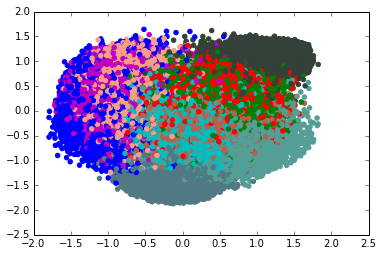

In [128]:
y = np.array(mnist_train_data['class'])
y = y.reshape(y.shape[0])

colours = ['#334138', '#517984', '#559e96', '#b3624d', '#f99f88', 'r', 'g', 'b', 'c', 'm']

for o, c in zip(pca_train_data, y):
    plt.scatter(o[0], o[1], color=colours[c])
    
plt.show()

Quality class separation is rather bed. Only boundary classes (blue, dark green, and grey) are distributed good to 
separate and classify. But other classes are mixed amound all graph and classification depending on this is rather bad.

There could be two reasons: 
Firstly, reduction from 30 to 2 must hurt quality and reducing it to two-dimensional data in order to visualize it 
is a bad idea. Maybe if showing it as a 3D-plot is better idea.
Secondly, some digits have similar (especially hand-written) way to write, have same shapes and neurons may learn 
also (but not nessesary) on those shapes. So, hand-written digits '6' and '8' easily can mislead neurons

#### Task 5-c

#### Neural network

In [147]:
from pybrain.utilities import percentError

print "Classification error using trained network = {0}".format(
    percentError(mnist_network.activateOnDataset(mnist_test_data), 
                 true=mnist_test_data['class']))


Classification error using trained network = 0.001


#### Pure kNN

In [148]:
from sklearn.neighbors.classification import KNeighborsClassifier as kNN

K = 3

X_train = mnist_train_data['input']
y_train = mnist_train_data['class']

y_train = np.reshape(y_train, (y_train.shape[0]))
knn = kNN(n_neighbors=K)
knn.fit(X_train, y_train)

X_test = mnist_test_data['input']
y_test = mnist_test_data['class']
y_test = np.reshape(y_test, y_test.shape[0])

print "Classification score using pure KNN on original images = {0}".format(
    knn.score(X_test, y_test))

Classification score using pure KNN on original images = 0.9705


#### kNN with neurons

In [146]:

X_train = mnist_train_transformed
y_train = mnist_train_data['class']

knn = kNN(n_neighbors=K)
knn.fit(X_train, y_train)

X_test = mnist_test_transformed
y_test = mnist_test_data['class']
y_test = np.reshape(y_test, (y_test.shape[0]))

knn_score = knn.score(X_test, y_test)

print "Classification score using KNN on hidden neuron activations = {0}".format(
    knn_score)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Classification score using KNN on hidden neuron activations = 0.9699


Defenetly, the worst approach for this task is pure kNN classifier.
It works extremly long and has one of the worst score value.
Explanation is easy: firstly, kNN cannot work on such big dimensions. As main kNN tool is finding an euclidian distance, complexity of finding it grows with dimensions polymomicaly.
Secondly, kNN suffers from big dataset, because complexity of finding some nearest neighboor is also proportional to number of points.

kNN is the tool that can be used in prepared and transformed dataset
with reduced dimencionality. This approach is used in second method.
Accuracy is worser a bit than in pure kNN, but it quicker hundred times more. 
Neural network runs with best accuracy (~99,9%), but speed of its training is horrible. Because neural networks use gradient descent for finding the weigths, time of its running grows with large num of iterations and dimension. With low epochs or dimensions (number of neurons in hidden layer) accuracy runs to 0. 

In task of digits recognition, best approach is to use neural network. It quicker than kNN (in second approach kNN used results of
network work) and more accurate. Also, in spite of kNN, neural network is less attituded to overfitting. Their learn is deeper, more efficient, but also require good optimization and parameter choise.

### Task 6

New feature space is more efficient in memory and time managment. No object recognitions are possible without image preprocessing. Because each pixel in image is a feature (so, another dimension), the most efficient way is to find some feature set, assosiated with some class and remove redutant. So, chance of overfitting is reduced, time is reduced and accuracy is reduced.

Disadvantage of this comes up with ways to change feature space: mostly, those methods are rather complex in non-trivial, so, complexity grows and bad implemented feature changing can break everything.